In [45]:
import os
import pickle
import pandas as pd
import geopandas as gpd
import folium
from folium import IFrame as iframe
import matplotlib.pyplot as plt, mpld3
import json

data_fout = os.path.join(os.path.dirname(os.getcwd()), 'data_out')

In [8]:
# Load the coloured samples subset
with open(os.path.join(data_fout, 'coloured.pickle'), 'rb') as f:
    coloured = pickle.load(f)
    
# Load the buffers subset
f = open(os.path.join(data_fout, "subbuffers.geojson"))
data_geojson_dict = json.load(f)
f.close()

In [71]:
def make_html_graph(samples, rin):
    fig = plt.figure()
    df = samples[samples['RIN'] == rin]
    fig.add_subplot(df.Au_ppm.hist())
    fig_html = mpld3.fig_to_html(fig)
    fig.set_title('Gold ppm')
    return fig_html

In [56]:
def save_json_graph(samples, rin):
    fig = plt.figure()
    df = samples[samples['RIN'] == rin]
    fig.add_subplot(df.Au_ppm.hist())
    mpld3.save_json(fig, os.path.join(data_fout, 'fig_%s.json'% rin))

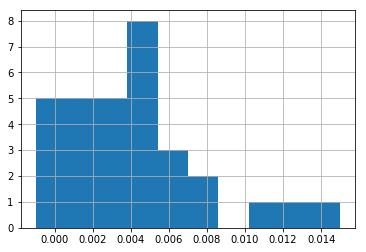

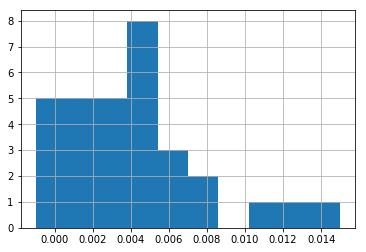

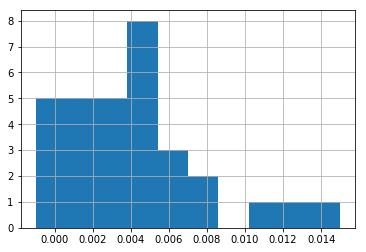

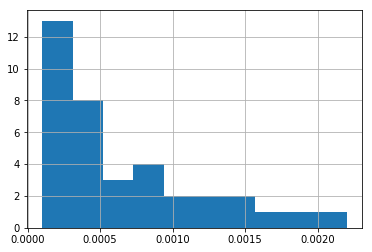

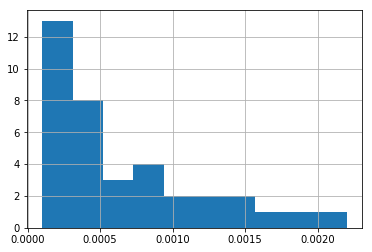

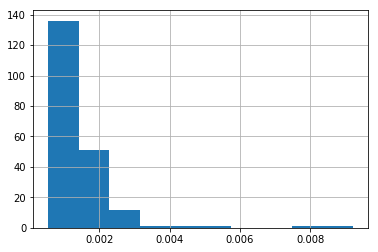

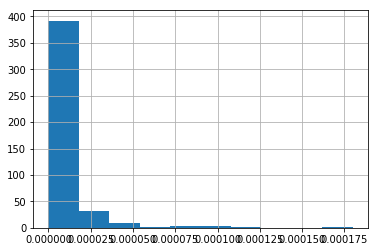

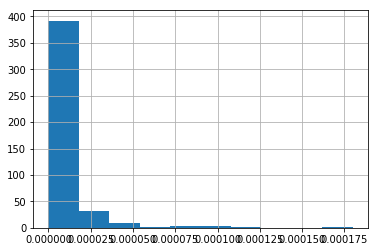

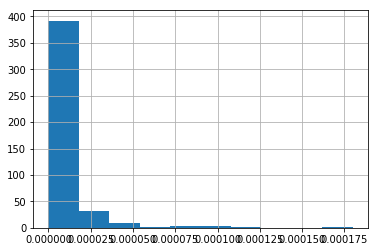

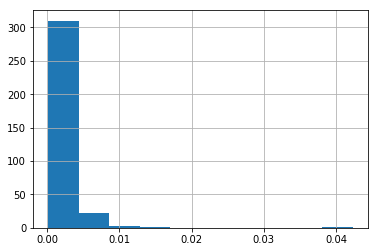

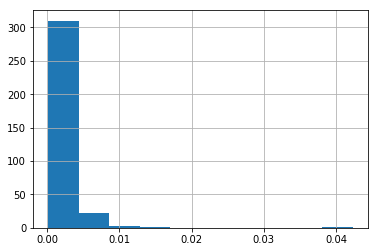

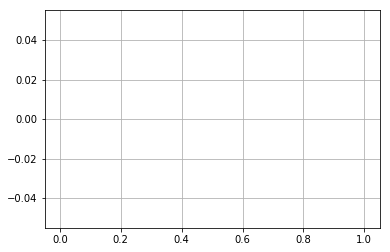

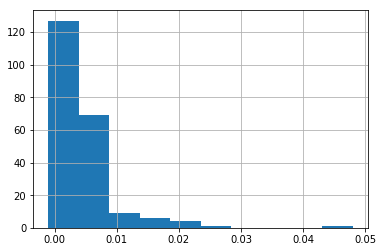

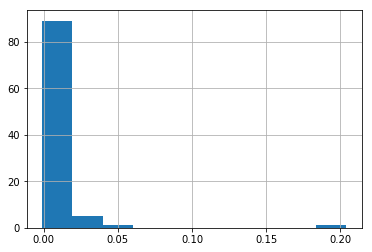

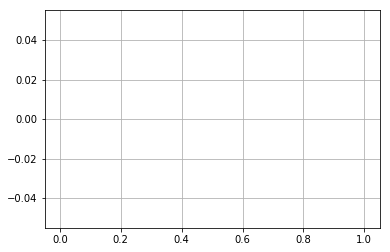

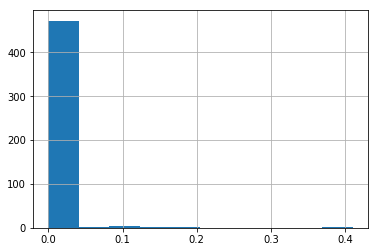

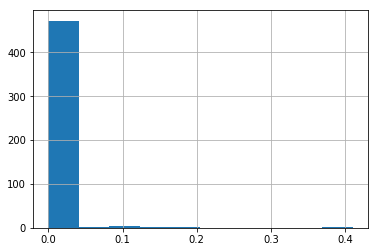

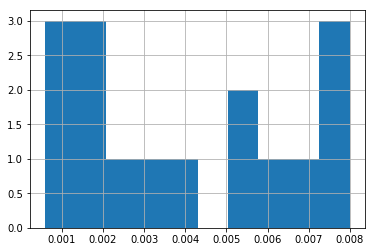

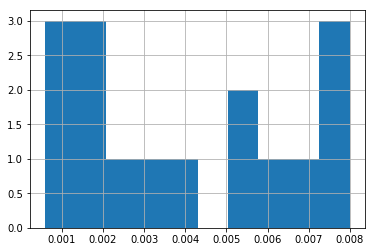

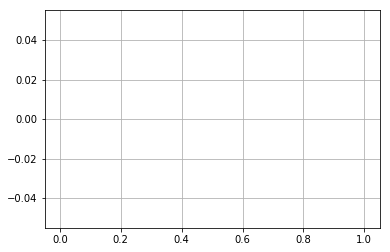

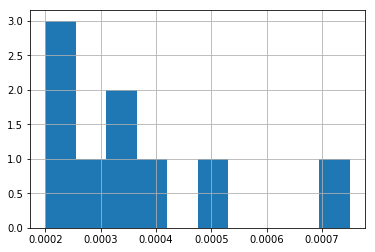

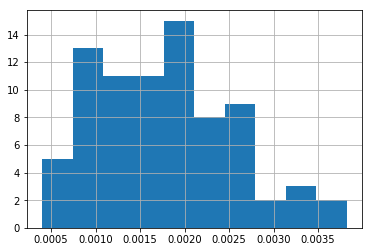

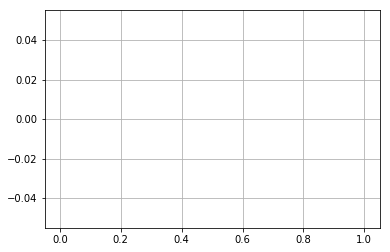

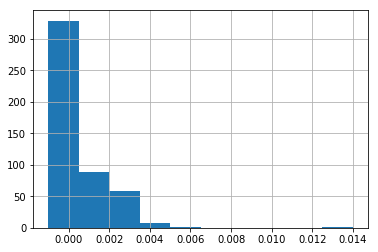

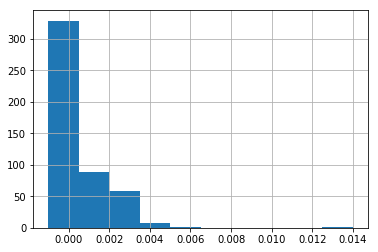

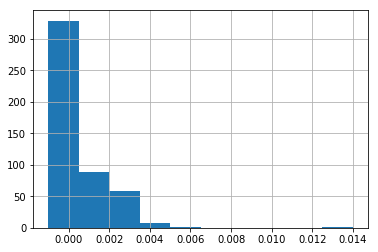

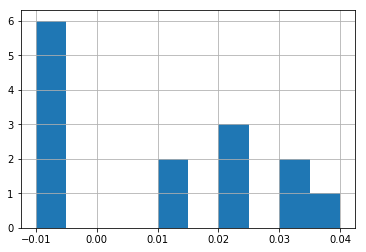

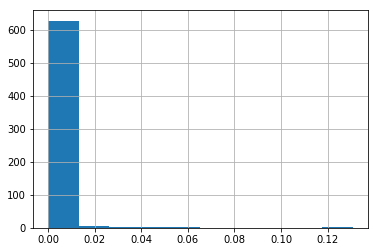

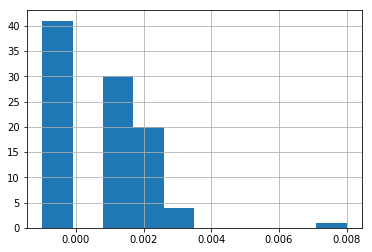

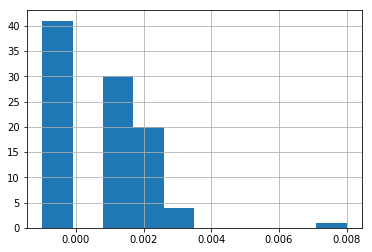

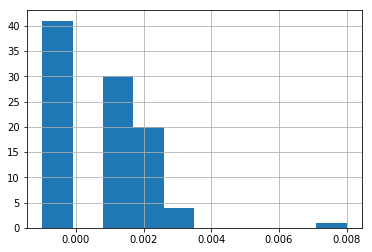

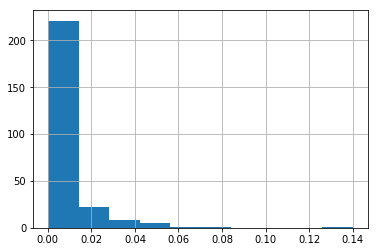

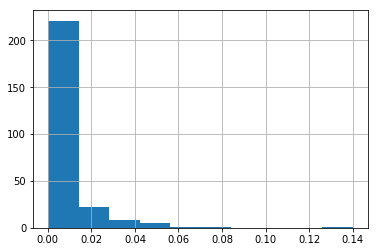

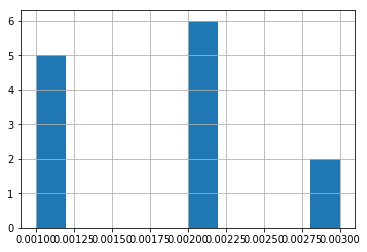

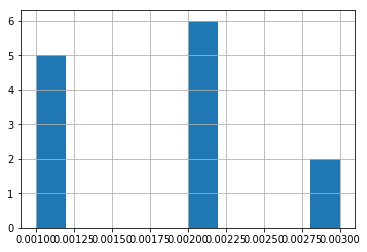

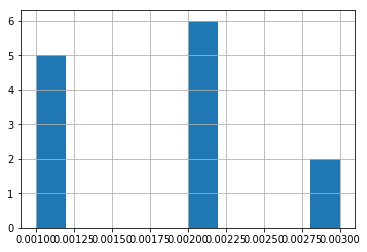

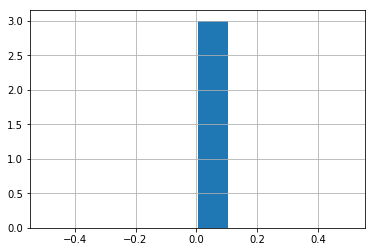

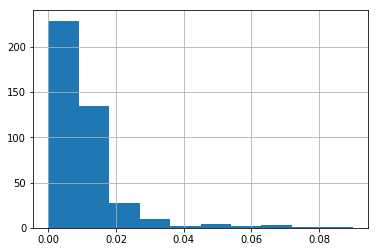

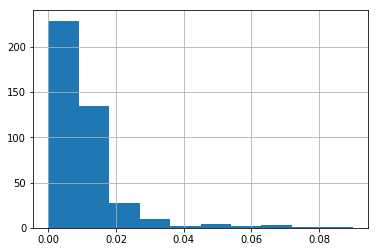

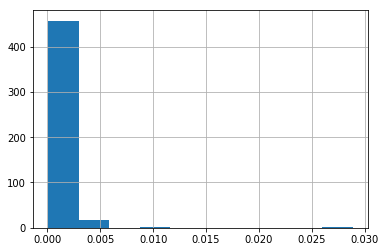

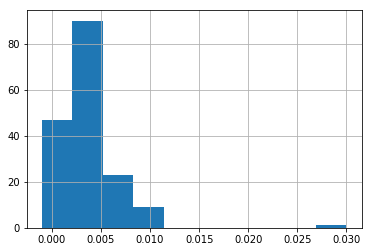

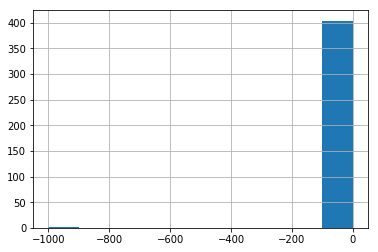

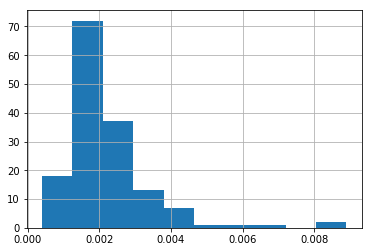

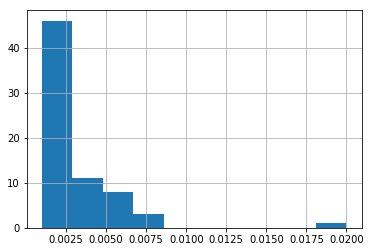

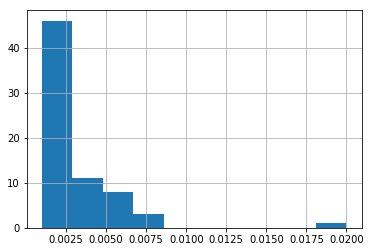

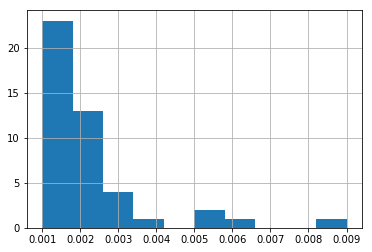

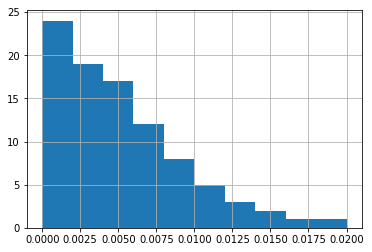

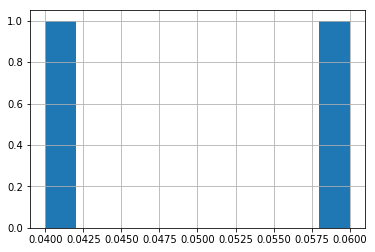

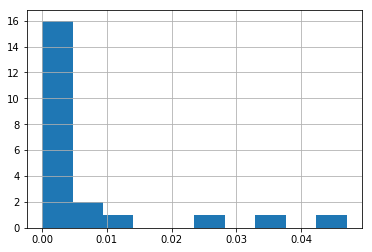

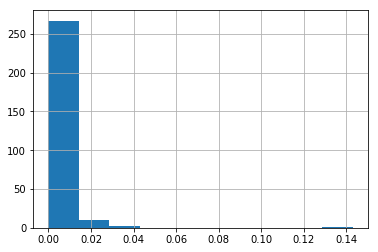

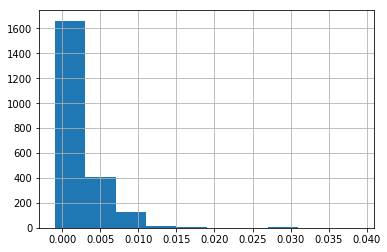

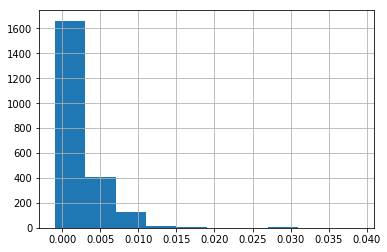

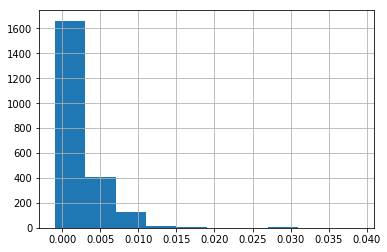

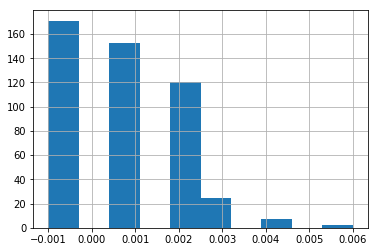

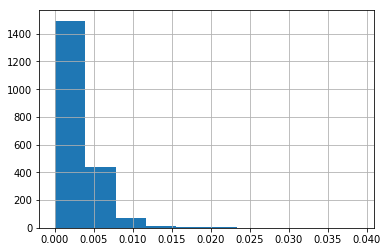

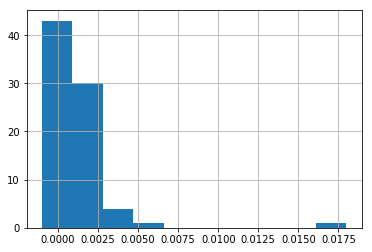

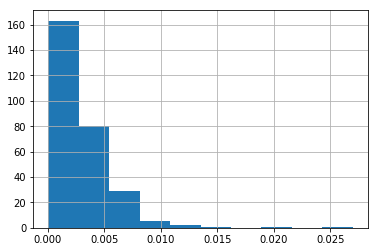

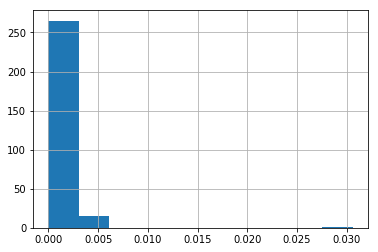

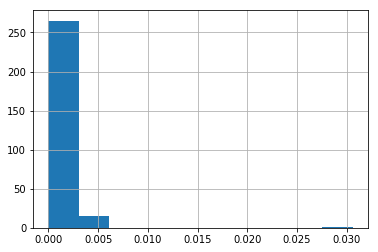

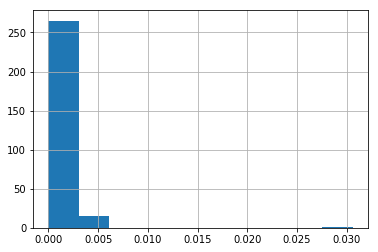

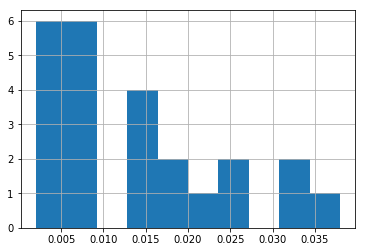

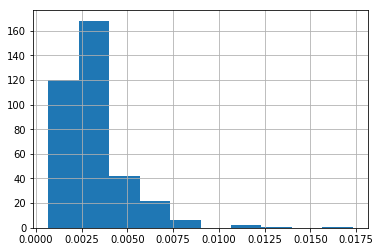

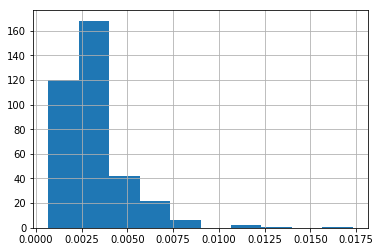

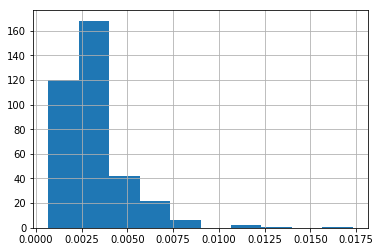

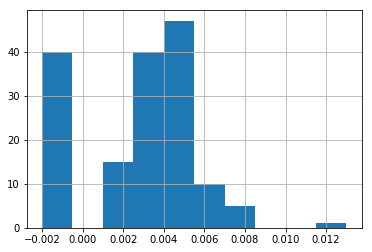

In [70]:
m = folium.Map(location=[-32, 141.5], zoom_start=9)
samples = folium.FeatureGroup(name="samples")
sample_points = list(zip(coloured.LAT94.values, coloured.LNG94.values, coloured.Au_ppm_nml.values, coloured.nat_breaks.values))

for lat, lng, au, colour in sample_points:
    samples.add_child(folium.CircleMarker(location=[lat, lng], radius=1.75,
        popup=str(au), 
        tooltip=str(au),
        fill=True,
        color=str(colour),
        fill_opacity=0.25)).add_to(m)

layer_geom = folium.FeatureGroup(name='layer',control=False)

for i in range(len(data_geojson_dict["features"])):
    temp_geojson = {"features":[data_geojson_dict["features"][i]],"type":"FeatureCollection"}
    
    temp_geojson_layer = folium.GeoJson(temp_geojson,
        highlight_function= lambda x: {'weight':3, 'color':'black'},          
        control=False,
        style_function=lambda feature: {'color': feature['properties']['stroke'],'weight': 1,'fill_opacity': 0.65},
        tooltip=folium.features.GeoJsonTooltip(fields=['rin'], labels=True, sticky=False)
                                       )
    rin = temp_geojson["features"][0]["properties"]["rin"]
    df = coloured[coloured['RIN'] == rin]
    g = make_html_graph(df, rin)
    graph = iframe(html=g, width=450, height=325)
    
    folium.Popup(graph).add_to(temp_geojson_layer)
    temp_geojson_layer.add_to(layer_geom)

layer_geom.add_to(m)

m.add_child(samples)
folium.LayerControl(autoZIndex=False, collapsed=True).add_to(m)
m.save(os.path.join(data_fout, "test_popups_coloured_v11.html"))